In [1]:
import random
import numpy as np

In [2]:
def get_size_a():
    size_a = [14,100,40,4]
    return size_a
    
def get_size_b():
    size_b = [14]
    for i in range(6):
        size_b.append(28)
    size_b.append(4)
    return size_b

def get_size_c():
    size_c = [14]
    for i in range(28):
        size_c.append(14)
    size_c.append(4)
    return size_c

In [3]:
# eg. a_list[-1] = convert_to_hot_vector(np.argmax(a_list[-1]), 4)
def convert_to_hot_vector(y, num_class):
    v = np.zeros(num_class)
    v[y] = 1
    v.shape = (num_class,1)
    return v

# eg. convert_to_hot_vectors(np.array([1, 0, 3]), 4)
def convert_to_hot_vectors(y_s, num_class):
    m = np.zeros((y_s.size, num_class))
    m[np.arange(y_s.size), y_s] = 1
    return m

In [4]:
def relu(x):
    r = x * (x > 0)
    r.shape = x.shape
    return r

def relu_derivative(x):
    d = np.array([1 if i>0 else 0 for i in x])
    d.shape = x.shape
    return d 

def softmax(x):
    """Compute softmax values for each value in x. Minus max to avoid large values in intermidiate steps"""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def cross_entropy(o,y):
    return -np.sum(np.multiply(y, np.log(o)))

In [5]:
class Network(object):
    def __init__(self, sizes, initial_b=None, initial_w=None):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = initial_b if initial_b else [np.random.random((y,1)) - 0.5 for y in sizes[1:]]
        self.weights = initial_w if initial_w else [np.random.random((y,x)) - 0.5 for x, y in zip(sizes[:-1], sizes[1:])]
        
    def feedforward(self, a):
        for b, w in zip(self.biases[0:-1], self.weights[0:-1]):
            a = relu(np.dot(w,a) + b)
        z = np.dot(self.weights[-1], a) + self.biases[-1]
        a = softmax(z)
        return a
    
    def stochastic_gradient_descent(self, training_data, iterations, mini_batch_size, learning_rate, test_data=None):
        """training_data is a list of tupes (x,y). ''test_data'' is used for cost & accuracy evaluation"""
        n = len(training_data)
        training_cost = np.zeros(iterations)
        test_cost = np.zeros(iterations)
        training_accuracy = np.zeros(iterations)
        test_accuracy = np.zeros(iterations)
        for i in range(iterations):
            training_cost[i], training_accuracy[i] = self.evaluate(training_data)
            print("Iter", i,": TrC: ", training_cost[i], "; TrA: ",training_accuracy[i])
            if test_data:
                test_cost[i], test_accuracy[i] = self.evaluate(test_data)
                print("Iter ", i,": TeC: ", test_cost[i], "; TeA: ", test_accuracy[i])
            random.shuffle(training_data)
            mini_batches = [training_data[k:k+mini_batch_size] for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_weights_biases(mini_batch, learning_rate)
            # evaluate cost & accuracy for training data and test data
        return (training_cost, training_accuracy, test_cost, test_accuracy)
    
    def update_weights_biases(self, mini_batch, learning_rate):
        """The ``mini_batch`` is a list of tuples ``(x, y)``."""
        sum_gradients_b = [np.zeros(b.shape) for b in self.biases]
        sum_gradients_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            gradients_b, gradients_w = self.backpropagate(x, y)
            sum_gradients_b = [sum_gb + gb for sum_gb, gb in zip(sum_gradients_b, gradients_b)]
            sum_gradients_w = [sum_gw + gw for sum_gw, gw in zip(sum_gradients_w, gradients_w)]
        self.biases = [b - learning_rate/len(mini_batch)*gb for b, gb in zip(self.biases, sum_gradients_b)]
        self.weights = [w - learning_rate/len(mini_batch)*gw for w, gw in zip(self.weights, sum_gradients_w)]
    
    def backpropagate(self, x, y):
        gradients_b = [np.zeros(b.shape) for b in self.biases]
        gradients_w = [np.zeros(w.shape) for w in self.weights]
        #feedforward
        a = x
        a_list = [x]
        z_list = []
        for b, w in zip(self.biases[0:-1], self.weights[0:-1]):
            z = np.dot(w, a) + b
            a = relu(z)
            a_list.append(a)
            z_list.append(z)
        z = np.dot(self.weights[-1], a_list[-1]) + self.biases[-1]
        a = softmax(z)
        a_list.append(a)
        z_list.append(z)
        # backward
        # for softmax-cross-entropy layer: delta in last layer = result - ground truth
        delta = a_list[-1] - y
        # update b and w for the last layer L
        gradients_b[-1] = delta
        gradients_w[-1] = np.dot(delta, a_list[-2].transpose())
        # update b and w for the rest of layers L-1, L-2, ... 
        for l in range(2, self.num_layers):
            z = z_list[-l]  # lth last layer of z
            r_derivative = relu_derivative(z)
            # update delta based on delta(l) = transpose of w(l+1) * delta(l+1)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * r_derivative
            gradients_b[-l] = delta
            gradients_w[-l] = np.dot(delta, a_list[-l-1].transpose())
        return (gradients_b, gradients_w)
    
    def evaluate(self, data):
        output = [self.feedforward(x) for x, y in data]
        cost = [cross_entropy(o, d[1]) for o, d in zip(output, data)]
        results = [(np.argmax(self.feedforward(x)), np.argmax(y)) for (x, y) in data]
        accuracy = sum(int(x == y) for (x, y) in results)/len(results)
        avg_cost = sum(cost)/len(cost)
        return (avg_cost, accuracy)

    

In [6]:
from numpy import genfromtxt
import os

# prepare data
userhome = os.path.expanduser('~')
shared_path = userhome + r'/Downloads/assignment1/Question2_123'
path_training_x = 'x_train.csv'
path_training_y = 'y_train.csv'
path_test_x = 'x_test.csv'
path_test_y = 'y_test.csv'
training_X =  genfromtxt(os.path.join(shared_path, path_training_x),delimiter=",")
training_Y =  genfromtxt(os.path.join(shared_path, path_training_y),delimiter=",")
training_data = [(x.reshape(14,1), convert_to_hot_vector(int(y),4)) for x, y in zip(training_X,training_Y)]
test_X =  genfromtxt(os.path.join(shared_path, path_test_x),delimiter=",")
test_Y =  genfromtxt(os.path.join(shared_path, path_test_y),delimiter=",")
test_data = [(x.reshape(14,1), convert_to_hot_vector(int(y),4)) for x, y in zip(test_X, test_Y)]
# print(training_data[0][1].shape)

In [7]:
%matplotlib inline 
import matplotlib.pyplot as plt

def save_to_file(title, training_cost, training_accuracy, test_cost, test_accuracy):
    userhome = os.path.expanduser('~')
    path = userhome + r'/Downloads/e0047338/toDelete'
    filename = os.path.join(path, title + '.txt')
    np.savetxt(filename, (training_cost, training_accuracy,test_cost,test_accuracy), delimiter=',', fmt='%1.4f')
    
def plot_graph(title, y_1, y_2, size, label_1, label_2, x_label, y_label):
    plt.figure(figsize=(15,7))
    plt.title(title)
    plt.plot(np.arange(0, size, 1), y_1, 'o-', label = label_1)
    plt.plot(np.arange(0, size, 1), y_2, 'o-', label = label_2)
    plt.grid() 
    plt.xlabel(x_label, fontsize=18)
    plt.ylabel(y_label, fontsize=18)
    plt.legend(loc='best', fontsize=16)

network_c = Network(get_size_c())
training_cost, training_accuracy, test_cost, test_accuracy = network_c.stochastic_gradient_descent(training_data, 500, 100, 0.01, test_data)

Iter 0 : TrC:  1.4056637994 ; TrA:  0.19798580911
Iter  0 : TeC:  1.40549875368 ; TeA:  0.202319194385
Iter 1 : TrC:  1.38040024494 ; TrA:  0.284428168154
Iter  1 : TeC:  1.38074584466 ; TeA:  0.288678669515
Iter 2 : TrC:  1.37748404658 ; TrA:  0.284428168154
Iter  2 : TeC:  1.37744524322 ; TeA:  0.288678669515
Iter 3 : TrC:  1.37684464681 ; TrA:  0.284428168154
Iter  3 : TeC:  1.3766814072 ; TeA:  0.288678669515
Iter 4 : TrC:  1.37677026552 ; TrA:  0.284428168154
Iter  4 : TeC:  1.37672843186 ; TeA:  0.288678669515
Iter 5 : TrC:  1.37676636228 ; TrA:  0.284428168154
Iter  5 : TeC:  1.37673244998 ; TeA:  0.288678669515
Iter 6 : TrC:  1.3768474651 ; TrA:  0.284428168154
Iter  6 : TeC:  1.37703723447 ; TeA:  0.288678669515
Iter 7 : TrC:  1.37678731461 ; TrA:  0.284428168154
Iter  7 : TeC:  1.37689419119 ; TeA:  0.288678669515
Iter 8 : TrC:  1.37677170896 ; TrA:  0.284428168154
Iter  8 : TeC:  1.37680162585 ; TeA:  0.288678669515
Iter 9 : TrC:  1.37678049677 ; TrA:  0.284428168154
Iter  9

Iter 77 : TrC:  1.37680125165 ; TrA:  0.284428168154
Iter  77 : TeC:  1.37664746797 ; TeA:  0.288678669515
Iter 78 : TrC:  1.37677398958 ; TrA:  0.284428168154
Iter  78 : TeC:  1.37674902192 ; TeA:  0.288678669515
Iter 79 : TrC:  1.37678098794 ; TrA:  0.284428168154
Iter  79 : TeC:  1.37669007014 ; TeA:  0.288678669515
Iter 80 : TrC:  1.37677265078 ; TrA:  0.284428168154
Iter  80 : TeC:  1.37676598161 ; TeA:  0.288678669515
Iter 81 : TrC:  1.37678383748 ; TrA:  0.284428168154
Iter  81 : TeC:  1.37670662013 ; TeA:  0.288678669515
Iter 82 : TrC:  1.37677354522 ; TrA:  0.284428168154
Iter  82 : TeC:  1.37664339503 ; TeA:  0.288678669515
Iter 83 : TrC:  1.37676377387 ; TrA:  0.284428168154
Iter  83 : TeC:  1.37671003149 ; TeA:  0.288678669515
Iter 84 : TrC:  1.37678017754 ; TrA:  0.284428168154
Iter  84 : TeC:  1.37686145446 ; TeA:  0.288678669515
Iter 85 : TrC:  1.37678218236 ; TrA:  0.284428168154
Iter  85 : TeC:  1.37681472506 ; TeA:  0.288678669515
Iter 86 : TrC:  1.37677860173 ; TrA: 

Iter 153 : TrC:  1.37679836188 ; TrA:  0.284428168154
Iter  153 : TeC:  1.3767371507 ; TeA:  0.288678669515
Iter 154 : TrC:  1.3767632365 ; TrA:  0.284428168154
Iter  154 : TeC:  1.37672895749 ; TeA:  0.288678669515
Iter 155 : TrC:  1.37690052942 ; TrA:  0.284428168154
Iter  155 : TeC:  1.37718026256 ; TeA:  0.288678669515
Iter 156 : TrC:  1.37685964088 ; TrA:  0.284428168154
Iter  156 : TeC:  1.37710122152 ; TeA:  0.288678669515
Iter 157 : TrC:  1.37677812019 ; TrA:  0.284428168154
Iter  157 : TeC:  1.37683762513 ; TeA:  0.288678669515
Iter 158 : TrC:  1.37680959709 ; TrA:  0.284428168154
Iter  158 : TeC:  1.37676866998 ; TeA:  0.288678669515
Iter 159 : TrC:  1.37677469416 ; TrA:  0.284428168154
Iter  159 : TeC:  1.37672371641 ; TeA:  0.288678669515
Iter 160 : TrC:  1.37679111161 ; TrA:  0.284428168154
Iter  160 : TeC:  1.37670483699 ; TeA:  0.288678669515
Iter 161 : TrC:  1.37677797117 ; TrA:  0.284428168154
Iter  161 : TeC:  1.37664965415 ; TeA:  0.288678669515
Iter 162 : TrC:  1.37

Iter  228 : TeC:  1.37665311662 ; TeA:  0.288678669515
Iter 229 : TrC:  1.37676924816 ; TrA:  0.284428168154
Iter  229 : TeC:  1.37670680099 ; TeA:  0.288678669515
Iter 230 : TrC:  1.37677798301 ; TrA:  0.284428168154
Iter  230 : TeC:  1.37665312313 ; TeA:  0.288678669515
Iter 231 : TrC:  1.37676475278 ; TrA:  0.284428168154
Iter  231 : TeC:  1.37668960306 ; TeA:  0.288678669515
Iter 232 : TrC:  1.37678809781 ; TrA:  0.284428168154
Iter  232 : TeC:  1.37655889383 ; TeA:  0.288678669515
Iter 233 : TrC:  1.37682185366 ; TrA:  0.284428168154
Iter  233 : TeC:  1.37648209716 ; TeA:  0.288678669515
Iter 234 : TrC:  1.37681666637 ; TrA:  0.284428168154
Iter  234 : TeC:  1.37673410068 ; TeA:  0.288678669515
Iter 235 : TrC:  1.37680645205 ; TrA:  0.284428168154
Iter  235 : TeC:  1.37675428046 ; TeA:  0.288678669515
Iter 236 : TrC:  1.37677366445 ; TrA:  0.284428168154
Iter  236 : TeC:  1.37683415669 ; TeA:  0.288678669515
Iter 237 : TrC:  1.37677821839 ; TrA:  0.284428168154
Iter  237 : TeC:  1

Iter 304 : TrC:  1.37676707114 ; TrA:  0.284428168154
Iter  304 : TeC:  1.37664799996 ; TeA:  0.288678669515
Iter 305 : TrC:  1.37677929375 ; TrA:  0.284428168154
Iter  305 : TeC:  1.37657809294 ; TeA:  0.288678669515
Iter 306 : TrC:  1.37682218314 ; TrA:  0.284428168154
Iter  306 : TeC:  1.37686200568 ; TeA:  0.288678669515
Iter 307 : TrC:  1.37678308951 ; TrA:  0.284428168154
Iter  307 : TeC:  1.37687242653 ; TeA:  0.288678669515
Iter 308 : TrC:  1.37676510804 ; TrA:  0.284428168154
Iter  308 : TeC:  1.37674843872 ; TeA:  0.288678669515
Iter 309 : TrC:  1.37677003118 ; TrA:  0.284428168154
Iter  309 : TeC:  1.37681225578 ; TeA:  0.288678669515
Iter 310 : TrC:  1.37682257908 ; TrA:  0.284428168154
Iter  310 : TeC:  1.37655274356 ; TeA:  0.288678669515
Iter 311 : TrC:  1.37679828862 ; TrA:  0.284428168154
Iter  311 : TeC:  1.37657198151 ; TeA:  0.288678669515
Iter 312 : TrC:  1.37682088236 ; TrA:  0.284428168154
Iter  312 : TeC:  1.37657061058 ; TeA:  0.288678669515
Iter 313 : TrC:  1.

Iter  379 : TeC:  1.37674114166 ; TeA:  0.288678669515
Iter 380 : TrC:  1.37676867745 ; TrA:  0.284428168154
Iter  380 : TeC:  1.37669248928 ; TeA:  0.288678669515
Iter 381 : TrC:  1.37678888251 ; TrA:  0.284428168154
Iter  381 : TeC:  1.37655759498 ; TeA:  0.288678669515
Iter 382 : TrC:  1.37676175793 ; TrA:  0.284428168154
Iter  382 : TeC:  1.37668602082 ; TeA:  0.288678669515
Iter 383 : TrC:  1.37678704442 ; TrA:  0.284428168154
Iter  383 : TeC:  1.37681279865 ; TeA:  0.288678669515
Iter 384 : TrC:  1.37678112149 ; TrA:  0.284428168154
Iter  384 : TeC:  1.3766491554 ; TeA:  0.288678669515
Iter 385 : TrC:  1.37680285554 ; TrA:  0.284428168154
Iter  385 : TeC:  1.37661267938 ; TeA:  0.288678669515
Iter 386 : TrC:  1.37677725297 ; TrA:  0.284428168154
Iter  386 : TeC:  1.37671910111 ; TeA:  0.288678669515
Iter 387 : TrC:  1.37676741432 ; TrA:  0.284428168154
Iter  387 : TeC:  1.37675214686 ; TeA:  0.288678669515
Iter 388 : TrC:  1.37676318161 ; TrA:  0.284428168154
Iter  388 : TeC:  1.

Iter 455 : TrC:  1.37685282335 ; TrA:  0.284428168154
Iter  455 : TeC:  1.3768900251 ; TeA:  0.288678669515
Iter 456 : TrC:  1.37679002048 ; TrA:  0.284428168154
Iter  456 : TeC:  1.37678742391 ; TeA:  0.288678669515
Iter 457 : TrC:  1.37677826363 ; TrA:  0.284428168154
Iter  457 : TeC:  1.37678366545 ; TeA:  0.288678669515
Iter 458 : TrC:  1.37676051154 ; TrA:  0.284428168154
Iter  458 : TeC:  1.37672071018 ; TeA:  0.288678669515
Iter 459 : TrC:  1.37676568699 ; TrA:  0.284428168154
Iter  459 : TeC:  1.37676693951 ; TeA:  0.288678669515
Iter 460 : TrC:  1.37679269927 ; TrA:  0.284428168154
Iter  460 : TeC:  1.37688065575 ; TeA:  0.288678669515
Iter 461 : TrC:  1.37681213109 ; TrA:  0.284428168154
Iter  461 : TeC:  1.37692488406 ; TeA:  0.288678669515
Iter 462 : TrC:  1.37678277869 ; TrA:  0.284428168154
Iter  462 : TeC:  1.37678361748 ; TeA:  0.288678669515
Iter 463 : TrC:  1.37677627601 ; TrA:  0.284428168154
Iter  463 : TeC:  1.37683924682 ; TeA:  0.288678669515
Iter 464 : TrC:  1.3

In [8]:
save_to_file('14-14-28-4', training_cost, training_accuracy, test_cost, test_accuracy)

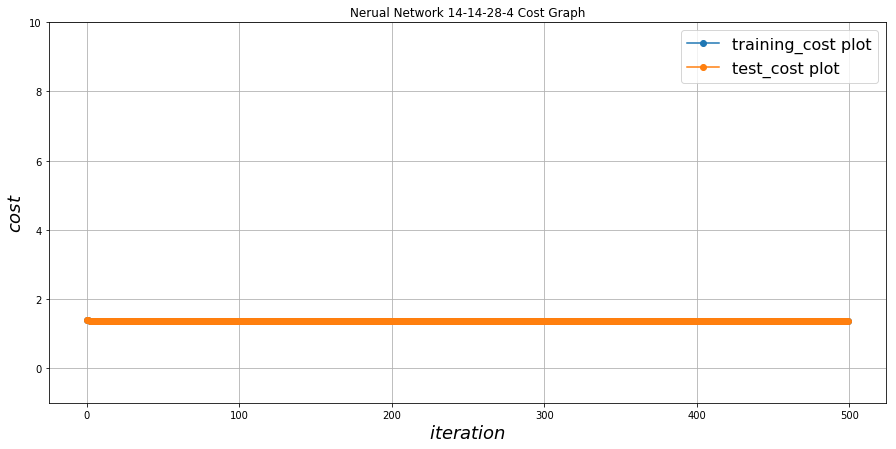

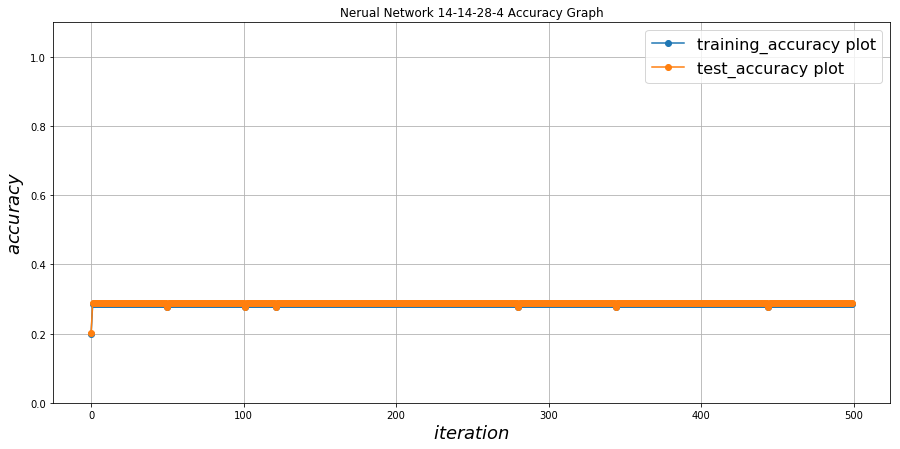

In [12]:
def plot_graph(title, y_1, y_2, size, label_1, label_2, x_label, y_label, y_lim):
    plt.figure(figsize=(15,7))
    plt.title(title)
    plt.plot(np.arange(0, size, 1), y_1, 'o-', label = label_1)
    plt.plot(np.arange(0, size, 1), y_2, 'o-', label = label_2)
    plt.grid() 
    plt.ylim(y_lim)
    plt.xlabel(x_label, fontsize=18)
    plt.ylabel(y_label, fontsize=18)
    plt.legend(loc='best', fontsize=16)

cost_title = 'Nerual Network 14-14-28-4 Cost Graph'
accuracy_title = 'Nerual Network 14-14-28-4 Accuracy Graph'
plot_graph(cost_title, training_cost, test_cost, training_cost.size, 'training_cost plot', 'test_cost plot', '$iteration$', '$cost$',(-1,10))
plot_graph(accuracy_title, training_accuracy, test_accuracy, training_accuracy.size, 'training_accuracy plot', 'test_accuracy plot', '$iteration$', '$accuracy$',(0,1.1))

In [10]:
def check_shape(list_of_arrays):
    shapes = [b.shape for b in list_of_arrays]
    print(shapes)

In [11]:
# import csv
# import os

# x = np.array([-1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1])
# x.shape = (14,1)
# y = convert_to_hot_vector(3,4)
# y.shape = (4,1)

# userhome = os.path.expanduser('~')
# shared_path = userhome + r'/Downloads/assignment1/Question2_4/b'
# path_b_a = 'b-100-40-4.csv'
# path_w_a = 'w-100-40-4.csv'
# path_b_b = 'b-28-6-4.csv'
# path_w_b = 'w-28-6-4.csv'
# path_b_c = 'b-14-28-4.csv'
# path_w_c = 'w-14-28-4.csv'

# def output_gradient(x, y, sizes, shared_path, path_b, path_w):
#     biases = [np.zeros((y,1)) for y in sizes[1:]]
#     weights = [np.zeros((y,x)) for x, y in zip(sizes[:-1],sizes[1:])]
#     with open(os.path.join(shared_path,path_b), newline='') as file:
#         reader = csv.reader(file)
#         for row, i in zip(reader,range(len(biases))):
#             biases[i] = np.array([np.float32(v) for v in row[1:]])
#             biases[i].shape = (len(row[1:]),1)
#     with open(os.path.join(shared_path,path_w), newline='') as file:
#         reader = csv.reader(file)
#         indexes = [sum(sizes[0:i+1])  for i in range(len(sizes))]
#         index = 0
#         wts = [w.transpose() for w in weights]
#         for row, i in zip(reader,range(sum(sizes[:-1]))):
#             index = index + 1 if i >= indexes[index] else index
#             index_w = i - indexes[index-1] if index > 0 else i
#             wts[index][index_w] = [np.float32(v) for v in row[1:]]
#     weights = [wt.transpose() for wt in wts]      
#     network_a = Network(sizes, biases, weights)
#     gradients_b, gradients_w = network_a.backpropagate(x, y)
#     path_db = os.path.join(shared_path,'d'+path_b)
#     path_dw = os.path.join(shared_path,'d'+path_w)
#     with open(path_db, 'w', newline='') as csvfile:
#         writer = csv.writer(csvfile, delimiter=',')
#         for gb in gradients_b:
#             n = [db[0] for db in gb]
#             writer.writerow(n)
#     with open(path_dw, 'w', newline='') as csvfile:
#         writer = csv.writer(csvfile, delimiter=',')
#         for gw in gradients_w:
#             dw = gw.transpose()
#             for row in dw:
#                 writer.writerow(row)
            

# output_gradient(x,y,get_size_a(),shared_path,path_b_a, path_w_a)
# print('complete a')
# output_gradient(x,y,get_size_b(),shared_path,path_b_b, path_w_b)
# print('complete b')
# output_gradient(x,y,get_size_c(),shared_path,path_b_c, path_w_c)
# print('complete c')

# shared_path = userhome + r'/Downloads/assignment1/Question2_4/c'
# output_gradient(x,y,get_size_a(),shared_path,path_b_a, path_w_a)
# print('complete test a')
# output_gradient(x,y,get_size_b(),shared_path,path_b_b, path_w_b)
# print('complete test b')
# output_gradient(x,y,get_size_c(),shared_path,path_b_c, path_w_c)
# print('complete test c')